# Reconstruction MILP

This notebook is needed for the MILP results reconstruction analysis.

Let's first generate a random circuit!



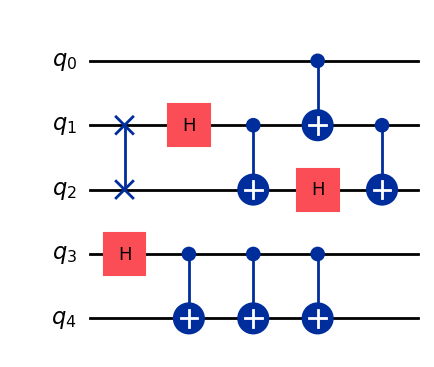

In [1]:
import qiskit.circuit.random
import qiskit
import qiskit.circuit.library.standard_gates
import random

import quariadne.circuit

QUBIT_COUNT = 5
NUM_GATES = 10
SEED = 156

random.seed(SEED)

MAX_OPERANDS = 2

STANDARD_GATE_SET = ["cx", "h", "swap"]



random_circuit = qiskit.QuantumCircuit(QUBIT_COUNT)
for operation_index in range(NUM_GATES):
    random_operation_label = random.choice(STANDARD_GATE_SET)
    if random_operation_label == "h":
        random_qubit = random.randint(0, QUBIT_COUNT-1)
        random_circuit.h(random_qubit)
    else:
        random_qubit_pair_first = random.randint(0, QUBIT_COUNT-2)
        random_qubit_pair_second = random_qubit_pair_first + 1

        if random_operation_label == "cx":
            random_circuit.cx(random_qubit_pair_first, random_qubit_pair_second)
        elif random_operation_label == "swap":
            random_circuit.swap(random_qubit_pair_first, random_qubit_pair_second)

random_circuit.draw('mpl')

Now let's generate random backend coupling map)

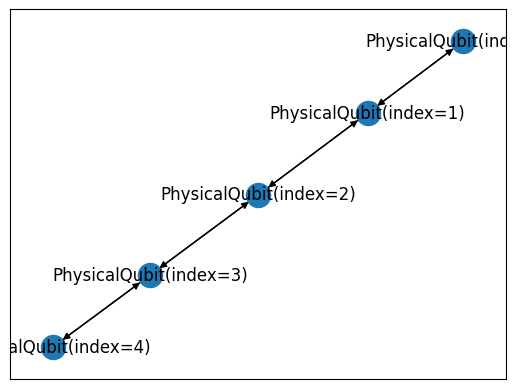

In [2]:
import qiskit_ibm_runtime.fake_provider 
import networkx as nx

manila_backend = qiskit_ibm_runtime.fake_provider.FakeManilaV2()
coupling_graph = manila_backend.coupling_map.graph
coupling_graph_nx = nx.DiGraph()

coupling_map_qubits = manila_backend.coupling_map.physical_qubits
physical_qubits = tuple(quariadne.circuit.PhysicalQubit(coupling_map_qubit) for coupling_map_qubit in coupling_map_qubits)
coupling_map_edgelist = manila_backend.coupling_map.graph.edge_list()
physical_qubits_connections = tuple((quariadne.circuit.PhysicalQubit(coupling_map_from), quariadne.circuit.PhysicalQubit(coupling_map_to)) for coupling_map_from, coupling_map_to in coupling_map_edgelist)
physical_qubits, physical_qubits_connections
coupling_graph_nx.add_nodes_from(physical_qubits)
coupling_graph_nx.add_edges_from(physical_qubits_connections)
nx.draw_networkx(coupling_graph_nx)

Finally, let's see an encapsulated version of the ciurcuti

In [3]:
random_abstract_circuit = quariadne.circuit.AbstractQuantumCircuit.from_qiskit_circuit(random_circuit)
random_abstract_circuit.operations

[QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=3),)),
 QuantumOperation(name='swap', qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2))),
 QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=1),)),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2))),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=4))),
 QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=2),)),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=1))),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2))),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=4))),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=4)))]

Let's initialise the milp router, and run it then!

In [ ]:
import quariadne.milp_router

milp_router = quariadne.milp_router.MilpRouter(coupling_graph_nx, random_abstract_circuit)
milp_router_result = milp_router._run_milp()
milp_router_result

(LogicalQubit(index=0), LogicalQubit(index=1), LogicalQubit(index=2), LogicalQubit(index=3), LogicalQubit(index=4))
logical_uniqueness_constraint (875, 36050) 1 1
physical_uniqueness_constraint (875, 36050) 1 1
gate_execution_constraint (7, 36050) 1 1
gate_mapping_constraint (56, 36050) 0 inf
gate_mapping_left_qubit_constraint (56, 36050) -inf 0
gate_mapping_right_qubit_constraint (56, 36050) -inf 0
gate_mapping_full_qubit_constraint (56, 36050) -1 inf
flow_condition_in_constraint (4350, 36050) 0 0
flow_condition_out_constraint (4375, 36050) 0 0


Let's reconstruct the mapping patterns then, and check that they are consistent. Maybe it is a better idea though to find the places where the swaps happen. 

In [ ]:
import numpy as np

reconstructed_movement_variables = np.zeros(milp_router.qubit_movement_shape)
movement_starting_index = milp_router.flat_mapping_variables_shape + milp_router.flat_gate_execution_variables_shape
movement_ending_index = len(milp_router_result.x)

for movement_idx in range(movement_starting_index, movement_ending_index):
    true_movement_index = movement_idx-movement_starting_index
    qubit_movement_position = np.unravel_index(true_movement_index, milp_router.qubit_movement_shape)
    reconstructed_movement_variables[qubit_movement_position] = milp_router_result.x[movement_idx]


reconstructed_movement_variables

And let's see if there is any swaps?

In [ ]:
defined_movements = np.argwhere(reconstructed_movement_variables)
for movement in defined_movements:
    timestep, logical_qubit, from_qubit, to_qubit = movement
    if from_qubit != to_qubit:
        print(movement)

No swaps! Let's generate another circuit then, and check it as well. 

In [ ]:
QUBIT_COUNT = 4
NUM_GATES = 10
SEED = 222

random.seed(SEED)

MAX_OPERANDS = 2

STANDARD_GATE_SET = ["cx", "h"]



random_broken_circuit = qiskit.circuit.random.random_clifford_circuit(QUBIT_COUNT, NUM_GATES, STANDARD_GATE_SET, seed=SEED)

random_broken_circuit.draw('mpl')

Perfect! Let's run the router then!

In [ ]:
random_broken_abstract_circuit = quariadne.circuit.AbstractQuantumCircuit.from_qiskit_circuit(random_broken_circuit)
milp_broken_router = quariadne.milp_router.MilpRouter(coupling_graph_nx, random_broken_abstract_circuit)
milp_broken_router_result = milp_broken_router._run_milp()
milp_broken_router_result

Sometimes the rounding error happen, so we will purge them down by the rounding operation. 

In [ ]:
milp_broken_result_variables = np.rint(milp_broken_router_result.x)
milp_broken_result_variables

In [ ]:
random_broken_abstract_circuit

Okay, let's reconstruct the solution, and check if everything is coherent. 

In [ ]:
import numpy as np

reconstructed_movement_variables = np.zeros(milp_broken_router.qubit_movement_shape)
movement_starting_index = milp_broken_router.flat_mapping_variables_shape + milp_broken_router.flat_gate_execution_variables_shape
movement_ending_index = len(milp_broken_result_variables)

for movement_idx in range(movement_starting_index, movement_ending_index):
    true_movement_index = movement_idx-movement_starting_index
    qubit_movement_position = np.unravel_index(true_movement_index, milp_broken_router.qubit_movement_shape)
    reconstructed_movement_variables[qubit_movement_position] = milp_broken_result_variables[movement_idx]


reconstructed_movement_variables

Detecting all the movements then :sunglasses:

In [ ]:
defined_movements = np.argwhere(reconstructed_movement_variables)
for movement in defined_movements:
    timestep, logical_qubit, from_qubit, to_qubit = movement
    if from_qubit != to_qubit:
        print(movement)

Okay, I'll check also the reconstructed mappings and the reconstructed gate execution, to see if everything is consistent.

In [ ]:
reconstructed_gate_execution = np.zeros(milp_broken_router.gate_execution_variables_shape)
execution_starting_index = milp_broken_router.flat_mapping_variables_shape
execution_ending_index = milp_broken_router.flat_mapping_variables_shape + milp_broken_router.flat_gate_execution_variables_shape

for execution_index in range(execution_starting_index, execution_ending_index):
    gate_execution_position = np.unravel_index(execution_index-execution_starting_index, milp_broken_router.gate_execution_variables_shape)
    reconstructed_gate_execution[gate_execution_position] = milp_broken_result_variables[execution_index]


reconstructed_gate_execution

And the corresponding executions are:

In [ ]:
defined_executions = np.argwhere(reconstructed_gate_execution)
for execution in defined_executions:
    timestep, operation_idx, edge_idx = execution
    print(execution, reconstructed_gate_execution[timestep])

Now let's check the final, the mappings, and go to the backend part!

In [ ]:
reconstructed_mapping = np.zeros(milp_broken_router.mapping_variables_shape)
mapping_starting_index = 0
mapping_ending_index = milp_broken_router.flat_mapping_variables_shape

for mapping_index in range(mapping_starting_index, mapping_ending_index):
    mapping_position = np.unravel_index(mapping_index-mapping_starting_index, milp_broken_router.mapping_variables_shape)
    reconstructed_mapping[mapping_position] = milp_broken_result_variables[mapping_index]


reconstructed_mapping

Checking the actual mappings!

In [ ]:
defined_mappings = np.argwhere(reconstructed_mapping)
for mapping in defined_mappings:
    timestep, physical_idx, logical_idx = mapping
    print(mapping)

Let's write the function for the initial mapping stage then!

In [ ]:
initial_mapping = np.argwhere(reconstructed_mapping[0])
initial_mapping

Great, moving to the closing of the thing, and transpiling the stuff. 

In [ ]:
from qiskit.transpiler import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=manila_backend, optimization_level=0, layout_method="trivial")
# ... and use it (as many times as you like).
physical = pm.run(random_broken_circuit)
physical.draw("mpl")

Beautiful. Let's then look into the transpiler, especially the routing engine itself.  Let's start with the layout decomposition anyway.

In [ ]:


class MILPLayoutPass(qiskit.transpiler.AnalysisPass):

    def run(self, dag):
        print(dag)
        


milp_layout_pass = MILPLayoutPass()
pm_empty = qiskit.transpiler.PassManager([milp_layout_pass])
pm_empty += qiskit.transpiler.preset_passmanagers.generate_embed_passmanager(coupling_graph)
pm_layout.run(random_broken_circuit)